# Classification Brain Tumor using CNN

## 🎯 Tujuan Pembelajaran
Memahami konsep Convolutional Neural Network (CNN) untuk klasifikasi gambar brain tumor.

##1. Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Mounting google drive (jika dataset atau data yang dibutuhkan disimpan di google drive)

##2. Import Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


📌 Fungsi import:

*   numpy → manipulasi array dan data numerik

*   matplotlib.pyplot → visualisasi gambar & plot training/validation

*   tensorflow → framework deep learning (build, train, save model)

*   Sequential → model CNN (linear stack)

*   Conv2D, MaxPooling2D, Flatten, Dense, Dropout → layer-layer utama CNN

*   EarlyStopping, ModelCheckpoint → callbacks untuk kontrol training & save model terbaik

*   ImageDataGenerator → load & augmentasi gambar dari folder dataset

*   classification_report → evaluasi model: precision, recall, F1-score

*   confusion_matrix → buat confusion matrix performa model

*   seaborn → visualisasi confusion matrix (heatmap)









##3. ImageDataGenerator → train/val split

In [4]:
# Path ke dataset
dataset_path = '/content/drive/MyDrive/brain_tumor_dataset'  # SESUAIKAN!!

# ImageDataGenerator dengan augmentasi & validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Training generator
train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(128,128),
    batch_size=16,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(128,128),
    batch_size=16,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 158 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


Pada tahap ini, digunakan ImageDataGenerator dari Keras untuk melakukan pemrosesan dan augmentasi data gambar secara otomatis sebelum diberikan ke model. Gambar-gambar MRI tumor otak yang terdapat dalam folder brain_tumor_dataset dikelompokkan ke dalam dua subfolder, yaitu yes untuk gambar yang mengandung tumor, dan no untuk gambar yang tidak mengandung tumor. Dengan memanfaatkan flow_from_directory(), gambar-gambar tersebut akan dibaca langsung dari folder dan diberi label sesuai nama subfoldernya.

Parameter rescale=1./255 digunakan untuk menormalkan nilai piksel dari rentang 0–255 menjadi 0–1, agar model lebih cepat dan stabil saat melakukan training. Augmentasi gambar dilakukan dengan beberapa transformasi seperti rotasi acak (rotation_range=20), zoom (zoom_range=0.2), shear (shear_range=0.1), dan flipping horizontal (horizontal_flip=True). Tujuan dari augmentasi ini adalah untuk memperluas variasi data latih tanpa harus menambah dataset secara manual, sehingga model dapat belajar lebih general dan tidak mudah overfitting.

Dataset dibagi secara otomatis menjadi dua subset menggunakan validation_split=0.2, di mana 80% data digunakan untuk training (subset='training') dan 20% sisanya untuk validasi (subset='validation'). Data training diacak setiap epoch (shuffle=True) agar model tidak mengingat urutan gambar. Sebaliknya, data validasi tidak diacak (shuffle=False) agar urutan tetap konsisten saat evaluasi model, terutama saat menghitung confusion matrix dan classification report.

Hasil dari proses ini menunjukkan bahwa sistem berhasil menemukan 158 gambar untuk training dan 38 gambar untuk validasi, yang berasal dari total 196 gambar di dalam dataset. Data ini kemudian akan digunakan sebagai input ke dalam model CNN untuk pelatihan dan evaluasi.



##4. Visualisasi data → contoh gambar

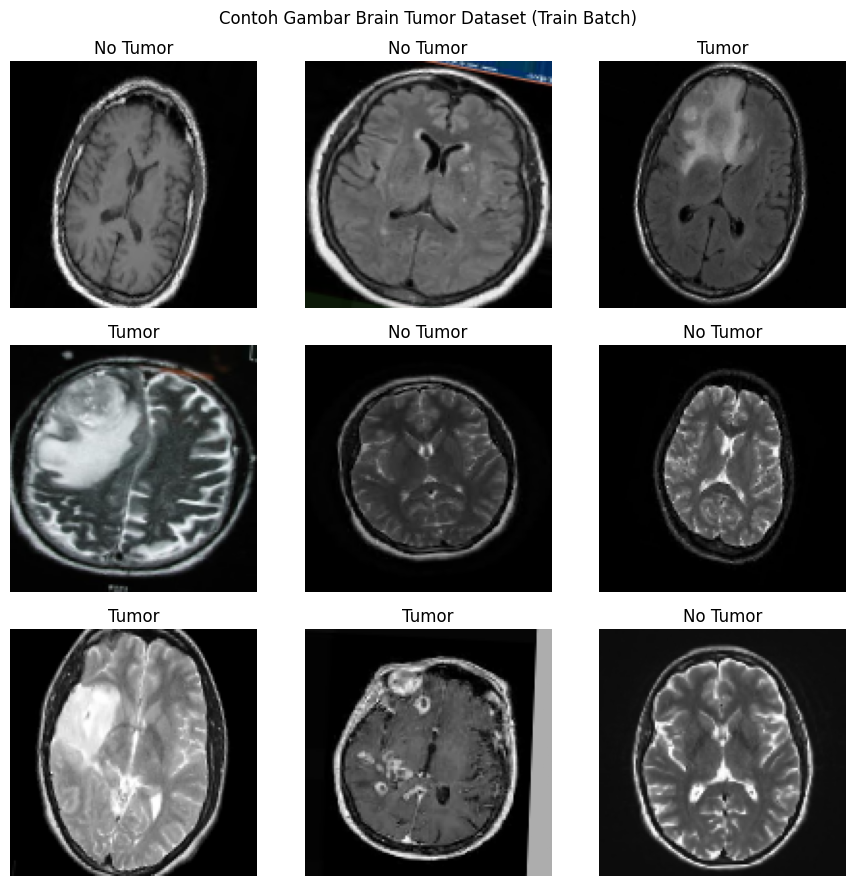

In [5]:
# Ambil 1 batch dari generator
images, labels = next(train_gen)

# Plot 9 gambar pertama
plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    label = "Tumor" if labels[i]==1 else "No Tumor"
    plt.title(label)
    plt.axis('off')
plt.suptitle("Contoh Gambar Brain Tumor Dataset (Train Batch)")
plt.tight_layout()
plt.show()


Pada tahap ini, dilakukan visualisasi beberapa contoh gambar yang dihasilkan oleh train_gen (generator untuk data training). Proses ini penting untuk memastikan bahwa proses ImageDataGenerator berjalan dengan benar, dan gambar-gambar yang dibaca dari folder sudah sesuai dengan label yang diberikan (Tumor atau No Tumor).

Kode ini mengambil satu batch gambar secara acak dari train_gen menggunakan next(train_gen), lalu menampilkan 9 gambar pertama. Masing-masing gambar divisualisasikan dengan label yang sesuai (Tumor jika label = 1, No Tumor jika label = 0).

Visualisasi ini berfungsi sebagai sanity check awal, untuk memverifikasi beberapa hal berikut:

1. Gambar yang digunakan memang merupakan gambar MRI otak.

2. Label yang diberikan oleh generator sesuai dengan isi gambar.

3. Proses preprocessing dan augmentasi (seperti resizing, flipping, dsb) berjalan dengan baik.

4. Tidak ada error dalam struktur folder dataset.

Dengan langkah ini, kita bisa memastikan bahwa data yang akan digunakan untuk melatih model CNN sudah dalam kondisi yang baik dan siap diproses. Ini adalah praktik umum yang sangat disarankan dalam proyek deep learning berbasis gambar.

##5. Build CNN → Binary Classification

In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Model CNN yang digunakan dirancang untuk melakukan klasifikasi biner gambar MRI tumor otak (Tumor / No Tumor). Arsitektur model terdiri dari kombinasi Conv2D + MaxPooling2D untuk ekstraksi fitur, dilanjutkan dengan Dense layer untuk klasifikasi akhir. Model ini cukup sederhana namun efektif untuk dataset dengan ukuran terbatas seperti Brain Tumor MRI.

Komponen model:

a. Conv2D (32 → 64 → 128 filters)
Mengekstraksi fitur visual dari gambar MRI secara bertahap.

b. MaxPooling2D
Mengurangi dimensi feature map agar model lebih efisien dan mengurangi overfitting.

c. Flatten
Mengubah output 3D CNN menjadi vektor 1D untuk input ke layer Dense.

d. Dense(128) + Dropout(0.5)
Fully connected layer untuk mempelajari kombinasi fitur penting, dengan Dropout untuk regularisasi.

e. Dense(1) + Sigmoid
Layer output yang menghasilkan probabilitas prediksi untuk klasifikasi Tumor / No Tumor.

Total parameter model adalah 3.3 juta, yang sebagian besar berasal dari koneksi antara Flatten ke Dense(128). Model ini cukup ringan untuk dijalankan di Colab atau perangkat dengan GPU.

##6. Callbacks → EarlyStopping + ModelCheckpoint

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_ckpt = ModelCheckpoint('best-brain-tumor-model.h5', monitor='val_accuracy', save_best_only=True)


Pada tahap ini, digunakan dua callback yang sangat umum dalam training model deep learning, yaitu EarlyStopping dan ModelCheckpoint. Callback ini membantu proses training menjadi lebih optimal dan aman.

Fungsi & manfaat:

1. EarlyStopping

* Memantau val_loss selama training.

* Jika dalam 10 epoch berturut-turut val_loss tidak membaik, training otomatis dihentikan.

* restore_best_weights=True → model akan otomatis kembali ke bobot terbaik (val_loss terendah).

* Tujuan utama: mencegah overfitting dan menghemat waktu training.

2. ModelCheckpoint

* Memantau val_accuracy selama training.

* Setiap kali model mencapai val_accuracy terbaik, model disimpan ke file 'best-brain-tumor-model.h5'.

* save_best_only=True → hanya model terbaik yang disimpan (tidak perlu menyimpan semua checkpoint).

* Manfaat: memastikan bahwa model yang disimpan benar-benar model terbaik berdasarkan akurasi validasi.

Penggunaan kedua callback ini membuat proses training menjadi lebih efisien, aman dari overfitting, dan memastikan hasil akhir model adalah versi terbaik yang didapat selama training.

##7. Training , save model→ plot accuracy & loss

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4684 - loss: 0.9131

10/10 ━━━━━━━━━━━━━━━━━━━━ 128s 13s/step - accuracy: 0.4742 - loss: 0.9030 - val_accuracy: 0.6579 - val_loss: 0.6603
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7476 - loss: 0.6397

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.7446 - loss: 0.6397 - val_accuracy: 0.7895 - val_loss: 0.5224
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.6440 - loss: 0.6401 - val_accuracy: 0.7632 - val_loss: 0.5901
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.5621 - loss: 0.6664 - val_accuracy: 0.7368 - val_loss: 0.5744
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.6815 - loss: 0.6366 - val_accuracy: 0.7368 - val_loss: 0.5217
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.7563 - loss: 0.5101 - val_accuracy: 0.7632 - val_loss: 0.4819
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.6393 - loss: 0.6268 - val_accuracy: 0.7632 - val_loss: 0.5131
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.7530 - loss: 0.5567 - val_accuracy: 0.7632 - val_loss: 0.5472
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7132 - loss: 0.5888 - val_accuracy: 0.7368 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.7283 - loss: 0.5402 - val_accuracy: 0.8158 - val_loss: 0.4681
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.7425 - loss: 0.5722 - val_accuracy: 0.7895 - val_loss: 0.4522
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.7794 - loss: 0.4813 - val_accuracy: 0.7368 - val_loss: 0.5323
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.8345 - loss: 0.4238 - val_accuracy: 0.7632 - val_loss: 0.6112
Epoch 16/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8018 - loss: 0.4344 - val_accuracy: 0.8158 - val_loss: 0.4541
Epoch 17/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.8173 - loss: 0.4239 - val_accuracy: 0.8158 - val_loss: 0.5821
Epoch 18/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8181 - loss: 0.4032

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.8185 - loss: 0.4067 - val_accuracy: 0.8421 - val_loss: 0.4785
Epoch 19/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.7754 - loss: 0.4309 - val_accuracy: 0.8421 - val_loss: 0.3885
Epoch 20/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.8845 - loss: 0.3807 - val_accuracy: 0.8421 - val_loss: 0.4807


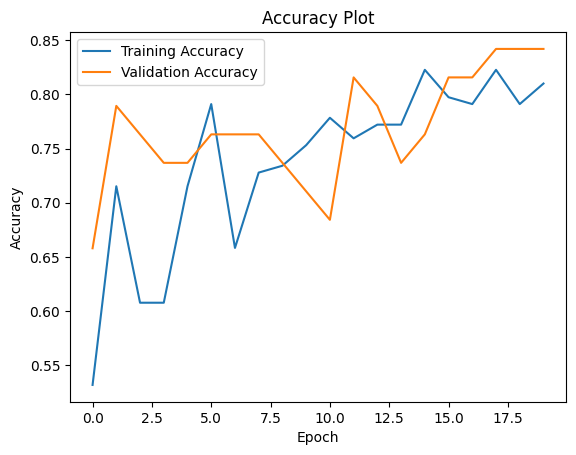

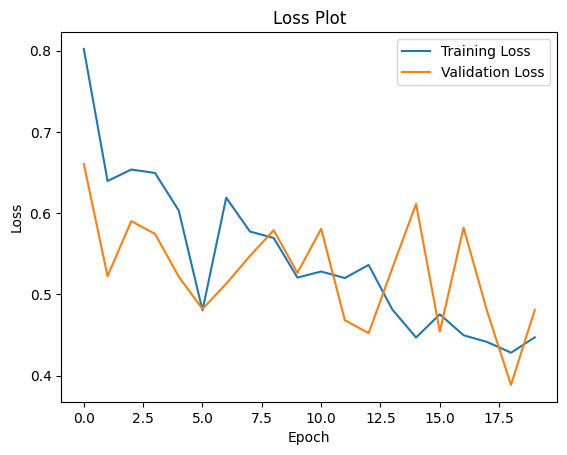

✅ Model saved to GDrive!


In [8]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stop, model_ckpt]
)

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Save model ke GDrive
model.save('/content/drive/MyDrive/brain-tumor-model/final-brain-tumor-model.h5')
print("✅ Model saved to GDrive!")



Setelah proses pelatihan model selama 20 epoch, dilakukan visualisasi terhadap akurasi dan loss untuk melihat perkembangan performa model dari waktu ke waktu. Grafik accuracy menunjukkan peningkatan konsisten baik pada data training maupun validation, dengan akurasi validasi mencapai sekitar 84% di akhir epoch. Hal ini menandakan bahwa model cukup baik dalam membedakan gambar MRI antara tumor dan non-tumor.

Pada grafik loss, terlihat tren penurunan yang stabil pada training loss, meskipun validation loss sempat mengalami fluktuasi ringan di beberapa titik. Namun secara umum, perbedaan antara training dan validation loss tidak terlalu besar, yang menunjukkan bahwa model tidak mengalami overfitting yang signifikan.

Model kemudian disimpan ke Google Drive menggunakan format .h5, memastikan hasil akhir dapat digunakan kembali tanpa perlu retraining. Proses penyimpanan otomatis dilakukan menggunakan ModelCheckpoint dan disimpan ulang secara eksplisit pada akhir training.



##8. Confusion Matrix, Classification Report

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


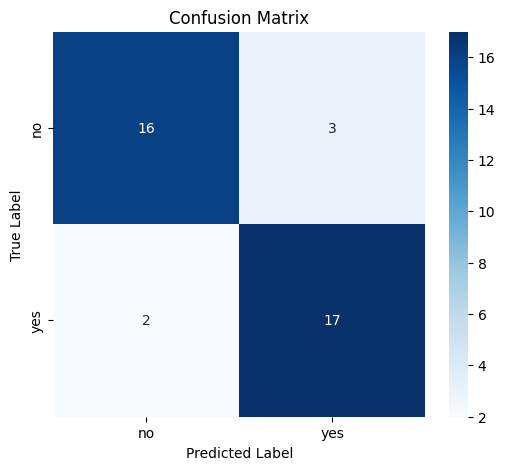

Classification Report:
              precision    recall  f1-score   support

          no       0.89      0.84      0.86        19
         yes       0.85      0.89      0.87        19

    accuracy                           0.87        38
   macro avg       0.87      0.87      0.87        38
weighted avg       0.87      0.87      0.87        38



In [9]:
# Reset validation generator (biar start dari awal)
val_gen.reset()

# Predict seluruh validation set
pred = model.predict(val_gen, verbose=1)
predicted_classes = (pred > 0.5).astype("int32").flatten()

# Ambil true label
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


Setelah model selesai dilatih, dilakukan evaluasi menggunakan data validasi untuk mengukur akurasi prediksi dengan lebih rinci. Berdasarkan confusion matrix, model berhasil mengklasifikasikan 16 gambar "No Tumor" dan 17 gambar "Tumor" dengan benar, sementara kesalahan prediksi masing-masing hanya 3 dan 2 kasus. Ini menunjukkan bahwa model memiliki kemampuan generalisasi yang cukup baik.

Laporan klasifikasi menunjukkan nilai precision sebesar 0.89 untuk kelas "no" dan 0.85 untuk kelas "yes", dengan recall yang saling melengkapi di angka 0.84 dan 0.89. Skor f1-score berkisar antara 0.86–0.87 untuk kedua kelas, dan akurasi keseluruhan model pada data validasi mencapai 87%. Nilai macro dan weighted average yang konsisten (semuanya 0.87) juga menandakan bahwa model memiliki performa yang seimbang dalam mendeteksi kedua kelas, baik Tumor maupun Non-Tumor.



##9. Test gambar

In [10]:
import cv2
import os

def load_and_predict(img_path, model_path='/content/drive/MyDrive/brain-tumor-model/final-brain-tumor-model.h5'):
    # Cek apakah model_path ada
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"❌ Model file not found: {model_path}")

    # Load model
    model = tf.keras.models.load_model(model_path)
    print(f"✅ Loaded model from: {model_path}")

    # Load & preprocess image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"❌ Failed to load image: {img_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=0)

    # Predict
    pred = model.predict(img_array, verbose=0)[0][0]
    label = "Tumor" if pred >= 0.5 else "No Tumor"
    confidence = pred if pred >= 0.5 else 1 - pred

    # Display image & prediction
    plt.imshow(img)
    plt.title(f"Predicted: {label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    return label, confidence


Fungsi load_and_predict() digunakan untuk melakukan prediksi klasifikasi tumor otak dari gambar MRI yang diunggah secara manual. Fungsi ini pertama-tama memeriksa apakah file model .h5 tersedia di path yang ditentukan (default: Google Drive). Jika ada, model akan dimuat menggunakan tf.keras.models.load_model().

Selanjutnya, gambar akan dibaca menggunakan cv2.imread(), diubah warnanya ke RGB, lalu di-resize menjadi ukuran 128x128 piksel agar sesuai dengan input model. Nilai piksel juga dinormalisasi ke rentang 0–1. Gambar kemudian diprediksi oleh model, dan hasilnya diubah menjadi label "Tumor" atau "No Tumor" tergantung pada probabilitas yang dihasilkan. Prediksi dan tingkat confidence ditampilkan secara visual menggunakan Matplotlib.

Fungsi ini sangat berguna untuk menguji model terhadap gambar baru dari luar dataset, seperti saat demo atau real-use-case aplikasi deteksi tumor berbasis citra.



Saving gambar1.jpg to gambar1.jpg
✅ Loaded model from: /content/drive/MyDrive/brain-tumor-model/final-brain-tumor-model.h5


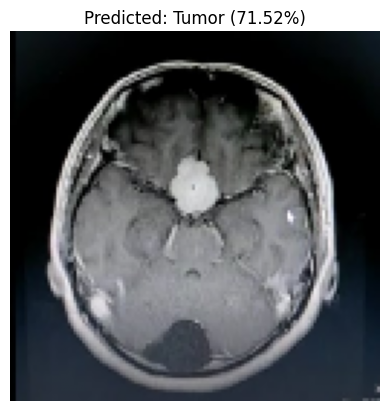

In [13]:
# Upload gambar manual
from google.colab import files
uploaded = files.upload()

# Test
for fname in uploaded.keys():
    load_and_predict(fname)


Pada bagian ini, pengguna dapat menguji model secara langsung dengan mengunggah gambar MRI otak dari luar dataset menggunakan files.upload() di Google Colab. Gambar yang diunggah kemudian diproses oleh fungsi load_and_predict(), yang akan melakukan preprocessing, prediksi, dan menampilkan hasil secara visual. Berdasarkan output, model berhasil mengklasifikasikan gambar dengan hasil “Tumor (71.52%)”, menunjukkan tingkat keyakinan model terhadap prediksi tersebut.

Proses ini sangat penting untuk evaluasi real-world karena menguji kemampuan model dalam mengenali pola pada gambar baru yang belum pernah dilihat sebelumnya. Selain itu, fitur ini juga dapat digunakan untuk integrasi ke aplikasi praktis seperti diagnosa berbasis gambar atau sistem deteksi otomatis. Meskipun muncul beberapa peringatan dari TensorFlow terkait retracing, hal tersebut tidak mempengaruhi akurasi prediksi dan umum terjadi dalam lingkungan dinamis seperti Colab.